In [1]:
import os
import numpy as np
import librosa
from scipy.io import wavfile
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import to_categorical

In [3]:
# Load the saved model (use '.keras' if it was saved in the new Keras format)
model = load_model("C:/Users/never/Desktop/Thesis/Thesis/Models/model.keras")

# Summary of the model to verify
model.summary()

C:\Users\never\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_12               │ (None, 250, 26, 1)          │           1,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 248, 24, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 248, 24, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 124, 12, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 124, 12, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 6, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 62, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 62, 128)             │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 62, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 62, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 62, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 62, 64)              │           8,256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 62, 32)              │           2,080 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 62, 32)              │             1

 Total params: 1,923,576 (7.34 MB)

 Trainable params: 961,249 (3.67 MB)

 Non-trainable params: 1,076 (4.20 KB)

 Optimizer params: 961,251 (3.67 MB)

In [5]:
# Load the Label Encoder
with open("C:/Users/never/Desktop/Thesis/Thesis/Models/label_encoder.pkl", "rb") as le_file:
    label_encoder = pickle.load(le_file)

In [6]:
# Directory where the test data is stored
test_data_dir = "C:/Users/never/Desktop/Thesis/Thesis/Data_T/clean_test"  # Update this with the actual path

_x_test = []
_y_test = []

In [7]:
# Step 1: Extract the test data and string labels (assuming labels are folder names)
for label in os.listdir(test_data_dir):
    label_dir = os.path.join(test_data_dir, label)

    # Only process if it's a folder (skip any non-folder files)
    if not os.path.isdir(label_dir):
        continue

    # Get all .wav files in the label folder
    file_names = [f for f in os.listdir(label_dir) if f.endswith(".wav")]

    # Process each audio file in the folder
    for f in tqdm(file_names, desc=f"Processing test label {label}"):
        # Extract MFCC features from the audio file
        rate, signal = wavfile.read(os.path.join(label_dir, f))
        mel = mfcc(signal, rate, nfilt=26, numcep=26, nfft=512)
        imarray = np.resize(mel, (250, 26))  # Resize or pad the MFCC features to a fixed size
        _x_test.append(imarray)

        # Append the label (string label from the folder name)
        _y_test.append(label)


Processing test label 5. Theme Jao: 100%|█████████████████████████████████████████████| 60/60 [00:00<00:00, 112.10it/s]


In [8]:
# Convert the list of features and labels into numpy arrays
x_test = np.array(_x_test, dtype="float32")
y_test = np.array(_y_test)

# Print total number of test cases
total_cases = len(x_test)
print(f"Total Number of Test Cases: {total_cases}")

# Step 2: Encode the string labels into numeric values using the same label encoder from training
y_test_encoded = label_encoder.transform(y_test)  # Convert string labels to numeric labels


Total Number of Test Cases: 300


In [9]:
# Step 3: Prepare the data for model testing
num_classes = len(label_encoder.classes_)  # Number of unique labels

# One-hot encode the test labels
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# Reshape the input data to match the expected input shape for the model
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [10]:
# Step 4: Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot)

# Print out test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - acc: 0.7996 - loss: 1.6909
Test Loss: 1.5438205003738403
Test Accuracy: 0.8100000023841858


In [11]:
# Step 5: Predict labels for each test example
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class indices


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step


In [14]:
# Step 6: Calculate binary accuracy for each class
label_accuracy = {}

# Loop over each unique label and calculate accuracy for that label
for label_index, label_name in enumerate(label_encoder.classes_):
    # Get indices for all instances of this label
    label_indices = np.where(y_test_encoded == label_index)[0]

    # Calculate accuracy for this label
    true_labels = y_test_encoded[label_indices]  # These are class indices
    predicted_labels = y_pred_labels[label_indices]  # These are also class indices

    correct_predictions = np.sum(true_labels == predicted_labels)
    total_predictions = len(label_indices)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    label_accuracy[label_name] = accuracy

print(label_accuracy)

{'1. Samne Jao': 0.8, '2. Pisone Jao': 0.8, '3. Dane Jao': 0.7666666666666667, '4. Bame Jao': 0.7833333333333333, '5. Theme Jao': 0.9}


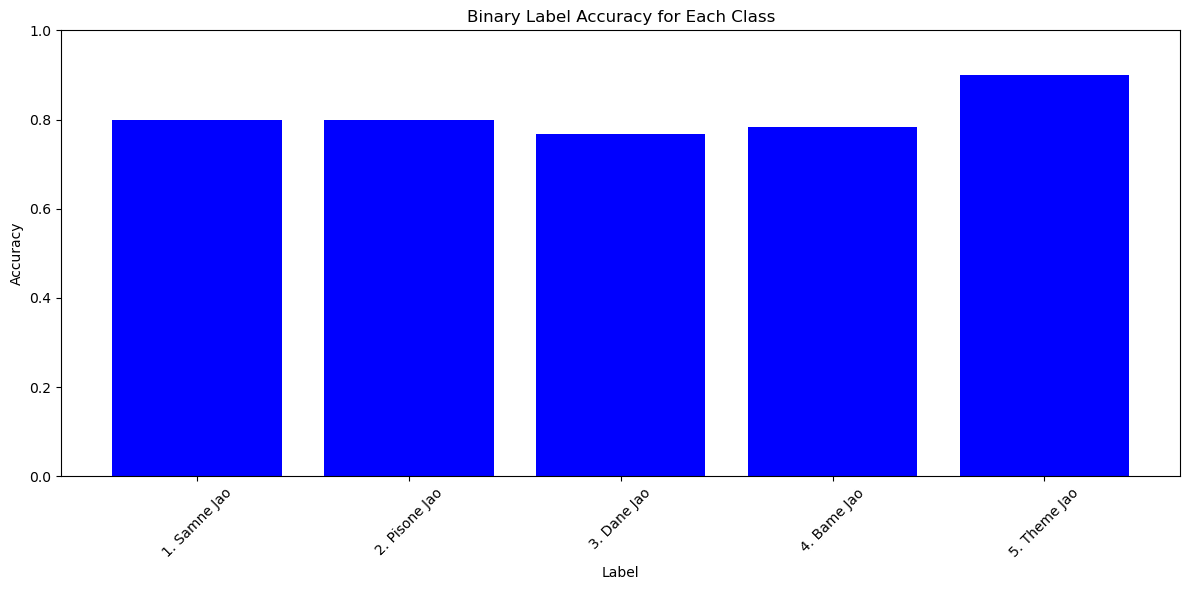

In [15]:
# Step 7: Plot the binary labeling accuracy for each class
plt.figure(figsize=(12, 6))
plt.bar(label_accuracy.keys(), label_accuracy.values(), color='b')
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.title('Binary Label Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

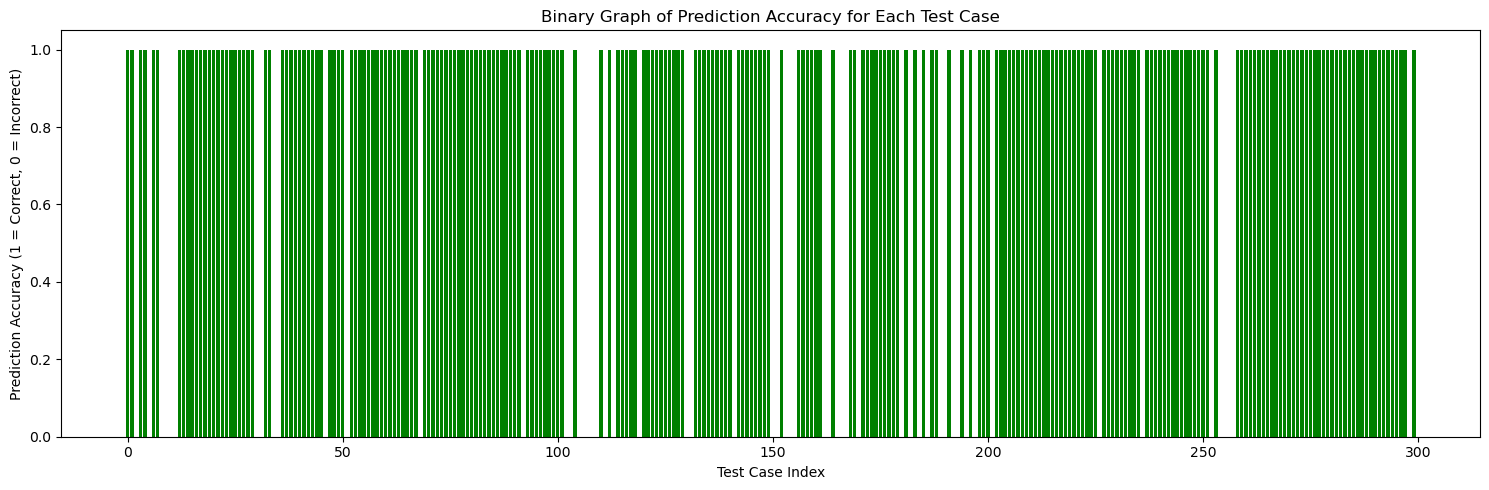

In [16]:
# Step 5: Calculate binary results for each test case
binary_results = []

# Loop over each test case
for i in range(len(y_test_encoded)):
    if y_test_encoded[i] == y_pred_labels[i]:
        binary_results.append(1)  # Correct prediction
    else:
        binary_results.append(0)  # Incorrect prediction

# Step 6: Plot the binary results for each test case
plt.figure(figsize=(15, 5))
plt.bar(range(len(binary_results)), binary_results, color=['g' if val == 1 else 'r' for val in binary_results])
plt.xlabel('Test Case Index')
plt.ylabel('Prediction Accuracy (1 = Correct, 0 = Incorrect)')
plt.title('Binary Graph of Prediction Accuracy for Each Test Case')
plt.tight_layout()
plt.show()

In [17]:
# Function to preprocess and predict the label of a single audio file
def predict_label_for_audio(audio_file_path):
    # Step 1: Load the audio file
    signal, rate = librosa.load(audio_file_path, sr=16000)

    # Step 2: Clean the audio using the envelope function
    mask = envelope(signal, rate, threshold=0.0005)
    clean_signal = signal[np.array(mask)]  # Apply the mask to clean the signal

    # Step 3: Extract MFCC features from the cleaned audio
    mel = mfcc(clean_signal, rate, nfilt=26, numcep=26, nfft=512)

    # Resize or pad MFCC to match the training input shape (250, 26)
    mfcc_features = np.resize(mel, (250, 26))

    # Step 4: Prepare the data for prediction (reshape to match model input)
    mfcc_features = mfcc_features.reshape(1, mfcc_features.shape[0], mfcc_features.shape[1], 1)

    # Step 5: Predict the label
    prediction = model.predict(mfcc_features)

    # Step 6: Decode the prediction to the label name
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])

    return predicted_label[0]

In [18]:
# Function to apply envelope-based noise reduction
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()

    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [19]:
# Test with a new audio file
audio_file_path = "C:/Users/never/Desktop/Thesis/Thesis/Master Test/Theme.wav"  # Update this path to your new audio file
predicted_label = predict_label_for_audio(audio_file_path)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Label: 5. Theme Jao


In [20]:
import sounddevice as sd

In [26]:
# Step: Record audio from live microphone and make a prediction
def record_audio(duration=3, fs=16000):
    print("Recording...")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording finished.")
    audio = audio.flatten()
    return audio, fs

In [27]:
# Predict label for new live-recorded audio
def predict_live_audio():
    # Record live audio from the microphone
    signal, rate = record_audio(duration=3, fs=16000)  # Record 3 seconds of audio

    # Apply envelope to clean the audio
    mask = envelope(signal, rate, threshold=0.0005)
    clean_signal = signal[np.array(mask)]

    # Extract MFCC features
    mel = mfcc(clean_signal, rate, nfilt=26, numcep=26, nfft=512)
    imarray = np.resize(mel, (250, 26))  # Resize or pad MFCC features to a fixed size

    # Prepare the input for the model
    imarray = imarray.reshape(1, imarray.shape[0], imarray.shape[1], 1)

    # Make prediction
    predictions = model.predict(imarray)
    predicted_label_index = np.argmax(predictions, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_label_index])

    print(f"Predicted Label: {predicted_label[0]}")

In [37]:
# Call the function to record and predict live audio
predict_live_audio()

Recording...
Recording finished.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: 5. Theme Jao
